In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
f_signal = ['/store/user/ekoenig/4BAnalysis/NTuples/feynnet/GluGluToHHTo4B/test_ntuple.root']
f_qcd = ['/store/user/ekoenig/4BAnalysis/NTuples/feynnet/QCD*bEn*/test_ntuple.root','/store/user/ekoenig/4BAnalysis/NTuples/feynnet/QCD*BGen*/test_ntuple.root']
f_tt = ['/store/user/ekoenig/4BAnalysis/NTuples/feynnet/TT*/test_ntuple.root']

In [3]:
signal = ObjIter([Tree(f_signal)])
bkg = ObjIter([Tree(f_qcd), Tree(f_tt)])

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


In [4]:
(signal+bkg).apply(lambda t : t.extend(n_all_jet=t.n_jet))

[None, None, None]

100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


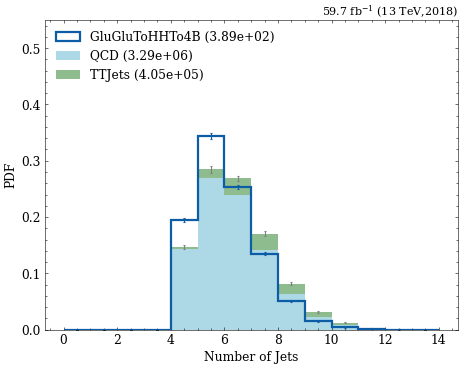

In [5]:
study.quick(
    signal+bkg,
    legend=True,
    varlist=['n_all_jet'],
    xlabels=['Number of Jets'],
    binlist=[np.arange(15)],
    # lumi=None,
    efficiency=True,
)

In [6]:
t4btag = CollectionFilter('jet', filter=lambda t : ak_rank(-t.jet_btag) < 6)
signal = signal.apply(t4btag, report=True)
bkg = bkg.apply(t4btag, report=True)
signal.apply(lambda t : t.extend(nfound_select=ak.sum(t.jet_signalId>-1,axis=1)))

CollectionFilter: 100%|██████████| 2/2 [00:27<00:00, 13.58s/it]


[None]

In [7]:
signal.apply(lambda t : (0.8/0.2)*ak.sum(t.nfound_select==4))

[54592.0]

In [8]:
bkg.apply(lambda t : (0.8/0.2)*len(t))

[298924.0, 2211892.0]

100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


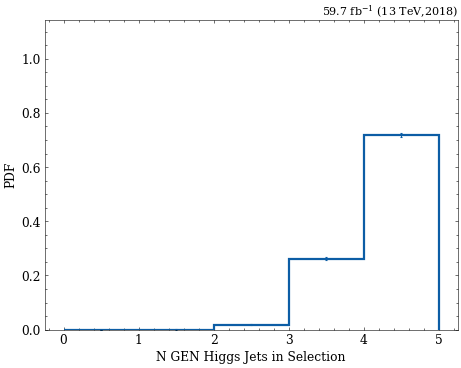

In [9]:
study.quick(
    signal,
    varlist=['nfound_select'],
    xlabels=['N GEN Higgs Jets in Selection'],
    efficiency=True,
)

In [10]:
from utils.fourbUtils import f_load_feynnet_assignment, models

load_feynnet = f_load_feynnet_assignment(models.feynnet_4b_6jet_bkg05_hm10.storage)

(signal+bkg).apply(load_feynnet, report=True)
(signal+bkg).apply(fourb.assign)

f_load_feynnet_assignment: 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


[None, None, None]

100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


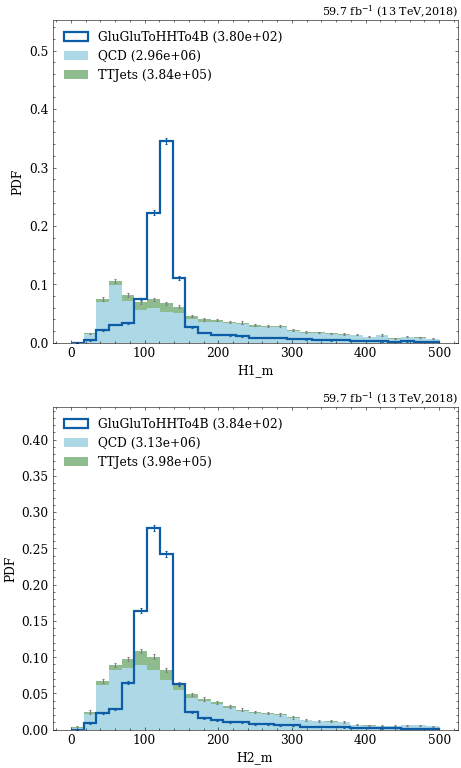

In [11]:
varinfo.H1_m = dict(bins=(0,500,30))
varinfo.H2_m = dict(bins=(0,500,30))

study.quick(
    signal+bkg,
    varlist=['H1_m','H2_m'],
    efficiency=True,
    dim=(2,-1),
    legend=True,
)

100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


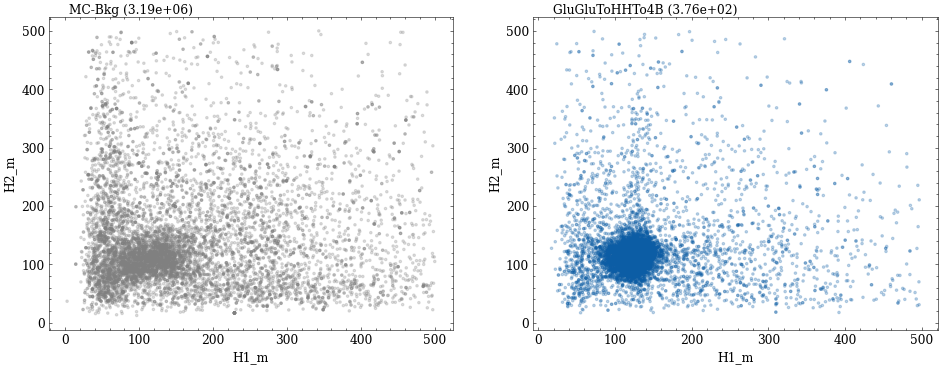

In [12]:
study.quick2d(
    signal+bkg,
    varlist=['H1_m','H2_m'],
    # binlist=[(0,500,15),(0,500,15)],
    size=(4,5),
    scatter=True,
    legend=True,
)

In [13]:
@tree_variable(xlabel='N GEN-B FeynNet')
def nfound_feynnet(t):
    return ak.sum(t.j_signalId>-1,axis=1)

@tree_variable(xlabel='N FeynNet Paired Higgs')
def nfound_feynnet_h(t):
    return ak.sum(t.h_signalId>-1,axis=1)

In [14]:
def n_feynnet_loose_btag(t):
    return ak.sum(t.j_btag>jet_btagWP[1],axis=1)

@tree_variable(xlabel='N FeynNet Medium BTag')
def n_feynnet_medium_btag(t):
    return ak.sum(t.j_btag>jet_btagWP[2],axis=1)
def n_all_medium_btag(t):
    return ak.sum(t.jet_btag>jet_btagWP[2],axis=1)
def n_feynnet_tight_btag(t):
    return ak.sum(t.j_btag>jet_btagWP[3],axis=1)

100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


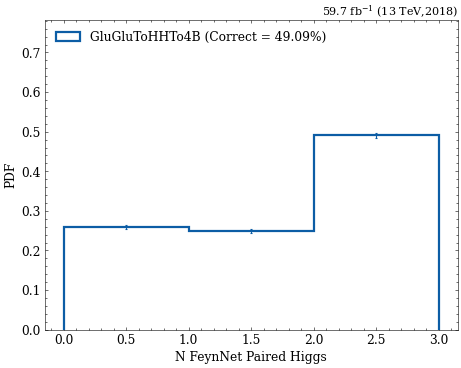

In [15]:
study.quick(
    signal,
    varlist=[nfound_feynnet_h],
    efficiency=True,
    h_label_stat=lambda h: f'Correct = {h.histo[-1]:0.2%}',
    legend=True,
)

In [16]:
def n_gen_medium_btag(t):
    btag = t.jet_btag
    signalId = t.jet_signalId
    return ak.sum(btag[signalId>-1]>jet_btagWP[2],axis=1)

100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


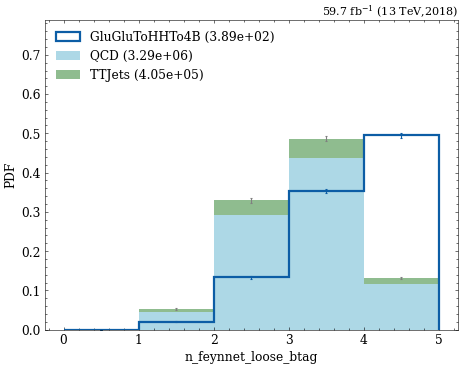

In [17]:
study.quick(
    signal+bkg,
    varlist=[n_feynnet_loose_btag],
    efficiency=True,
    legend=True,
)

100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


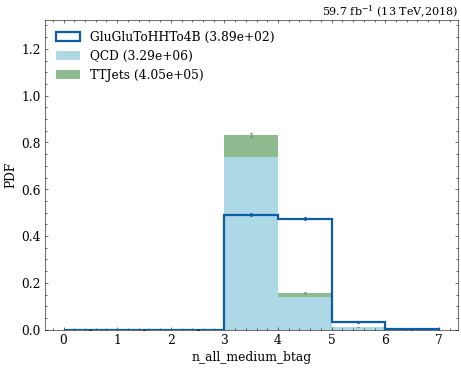

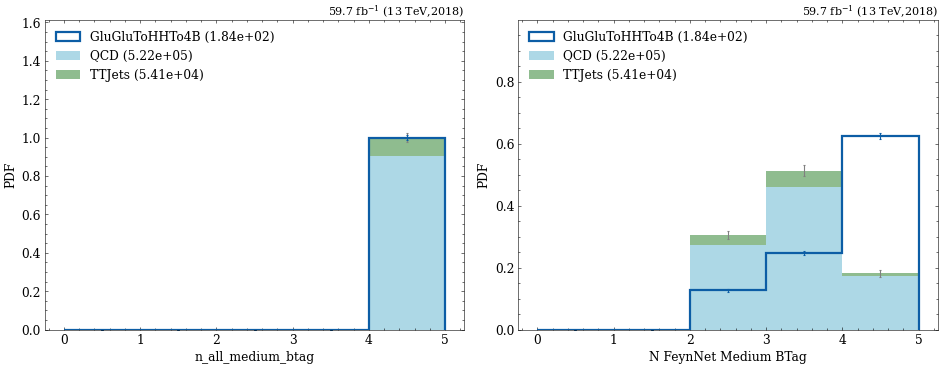

In [18]:
study.quick(
    signal+bkg,
    varlist=[n_all_medium_btag],
    efficiency=True,
    legend=True,
)

study.quick(
    signal+bkg,
    masks=lambda t : n_all_medium_btag(t)==4,
    varlist=[n_all_medium_btag, n_feynnet_medium_btag],
    efficiency=True,
    legend=True,
)

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


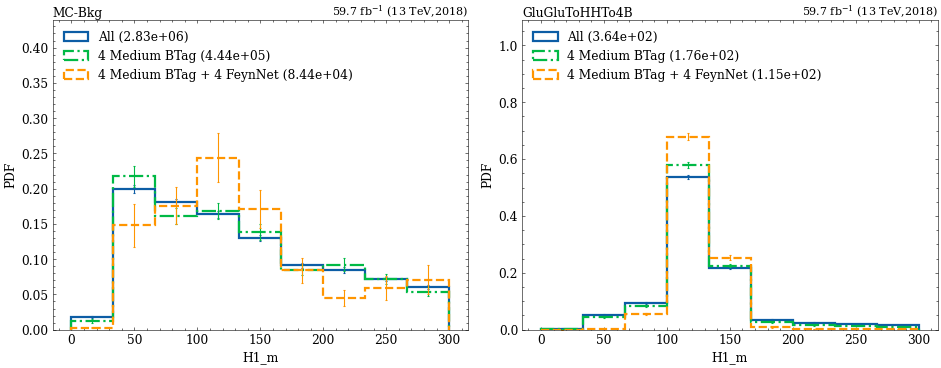

In [19]:


study.compare_masks(
    signal,bkg,
    h_color=None,
    masks=[None, lambda t : n_all_medium_btag(t)==4, lambda t : (n_all_medium_btag(t)==4)&(n_feynnet_medium_btag(t)==4)],
    label=['All', '4 Medium BTag', '4 Medium BTag + 4 FeynNet'],
    varlist=['H1_m'],
    binlist=[(0,300,30)],
    h_rebin=10,
    efficiency=True,
    legend=True,
)

100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


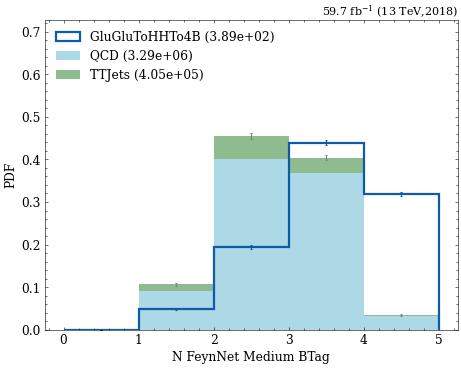

In [20]:
study.quick(
    signal+bkg,
    varlist=[n_feynnet_medium_btag],
    efficiency=True,
    legend=True,
)

100%|██████████| 1/1 [00:00<00:00, 27.65it/s]


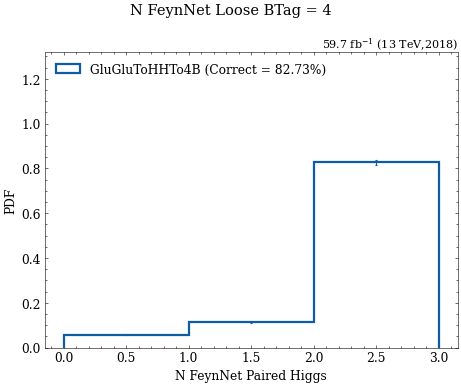

In [21]:
study.quick(
    signal,
    masks=lambda t : n_feynnet_loose_btag(t)==4,
    varlist=[nfound_feynnet_h],
    efficiency=True,
    h_label_stat=lambda h: f'Correct = {h.histo[-1]:0.2%}',
    suptitle='N FeynNet Loose BTag = 4',
    legend=True,
)

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


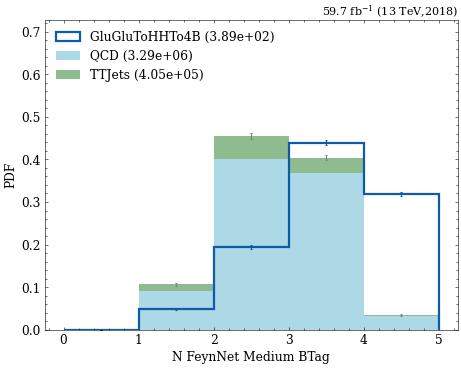

In [22]:
study.quick(
    signal+bkg,
    varlist=[n_feynnet_medium_btag],
    efficiency=True,
    legend=True,
)

100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


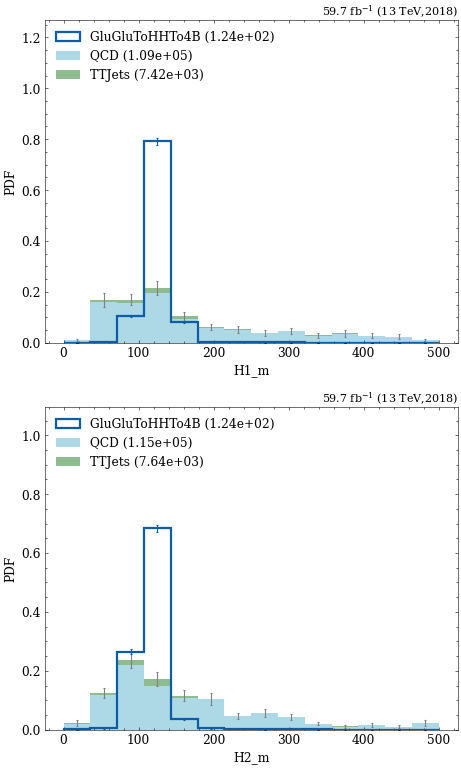

In [23]:
varinfo.H1_m = dict(bins=(0,500,30))
varinfo.H2_m = dict(bins=(0,500,30))

study.quick(
    signal+bkg,
    masks=lambda t : n_feynnet_medium_btag(t)==4,
    varlist=['H1_m','H2_m'],
    h_rebin=15,
    efficiency=True,
    dim=(2,-1),
    legend=True,
)

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


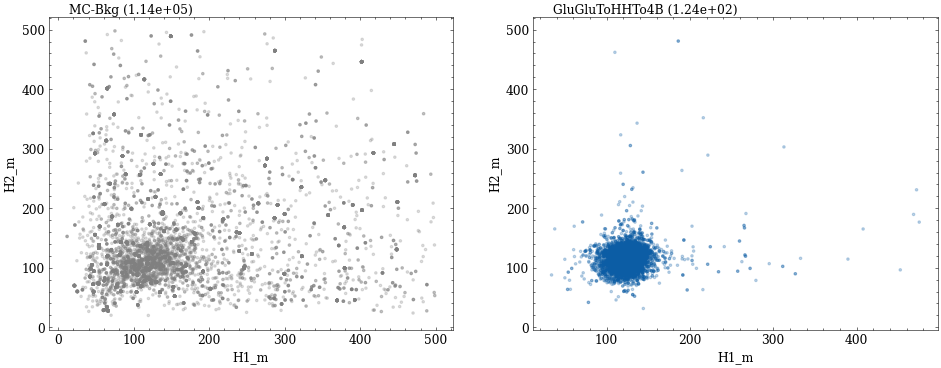

In [24]:
study.quick2d(
    signal+bkg,
    masks=lambda t : n_feynnet_medium_btag(t)==4,
    varlist=['H1_m','H2_m'],
    # binlist=[(0,500,15),(0,500,15)],
    size=(4,5),
    scatter=True,
    # interp=True,
    legend=True,
)